## K-Means

#### VISUALIZER

In [21]:
def visualize_clusters_3d(X, clusters, cluster_means, title="Color Clusters in RGB Space"):
    """
    Create a 3D scatter plot of color clusters
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Sample points to reduce plotting time (take every nth point)
    sample_rate = max(1, len(X) // 1000)  # Limit to ~1000 points
    
    # Plot sample of points
    for i in range(len(cluster_means)):
        mask = clusters == i
        sampled_points = X[mask][::sample_rate]
        if len(sampled_points) > 0:
            ax.scatter(
                sampled_points[:, 0],
                sampled_points[:, 1],
                sampled_points[:, 2],
                alpha=0.5,
                label=f'Cluster {i}'
            )
    
    # Plot cluster centers
    ax.scatter(
        cluster_means[:, 0],
        cluster_means[:, 1],
        cluster_means[:, 2],
        c='black',
        marker='x',
        s=200,
        linewidth=3,
        label='Centroids'
    )
    
    ax.set_xlabel('Red')
    ax.set_ylabel('Green')
    ax.set_zlabel('Blue')
    ax.set_title(title)
    ax.legend()
    plt.show()

def visualize_clusters_2d(X, clusters, cluster_means, title="Color Clusters - 2D Projections"):
    """
    Create 2D scatter plots for each pair of color channels
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    channels = [(0, 1, 'Red', 'Green'), (0, 2, 'Red', 'Blue'), (1, 2, 'Green', 'Blue')]
    
    # Sample points to reduce plotting time
    sample_rate = max(1, len(X) // 1000)  # Limit to ~1000 points
    
    for ax, (i, j, xlabel, ylabel) in zip(axes, channels):
        # Plot sample of points
        for cluster_idx in range(len(cluster_means)):
            mask = clusters == cluster_idx
            sampled_points = X[mask][::sample_rate]
            if len(sampled_points) > 0:
                ax.scatter(
                    sampled_points[:, i],
                    sampled_points[:, j],
                    alpha=0.5,
                    label=f'Cluster {cluster_idx}'
                )
        
        # Plot cluster centers
        ax.scatter(
            cluster_means[:, i],
            cluster_means[:, j],
            c='black',
            marker='x',
            s=200,
            linewidth=3,
            label='Centroids'
        )
        
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

#### K-MEANS CPU

Processing time: 2.97 seconds

Cluster Distribution:
Cluster 0: 8725 pixels (0.94%)
Cluster 1: 183494 pixels (19.69%)
Cluster 2: 83253 pixels (8.93%)
Cluster 3: 135766 pixels (14.57%)
Cluster 4: 49665 pixels (5.33%)
Cluster 5: 175320 pixels (18.81%)
Cluster 6: 33810 pixels (3.63%)
Cluster 7: 87849 pixels (9.43%)
Cluster 8: 88291 pixels (9.47%)
Cluster 9: 85667 pixels (9.19%)


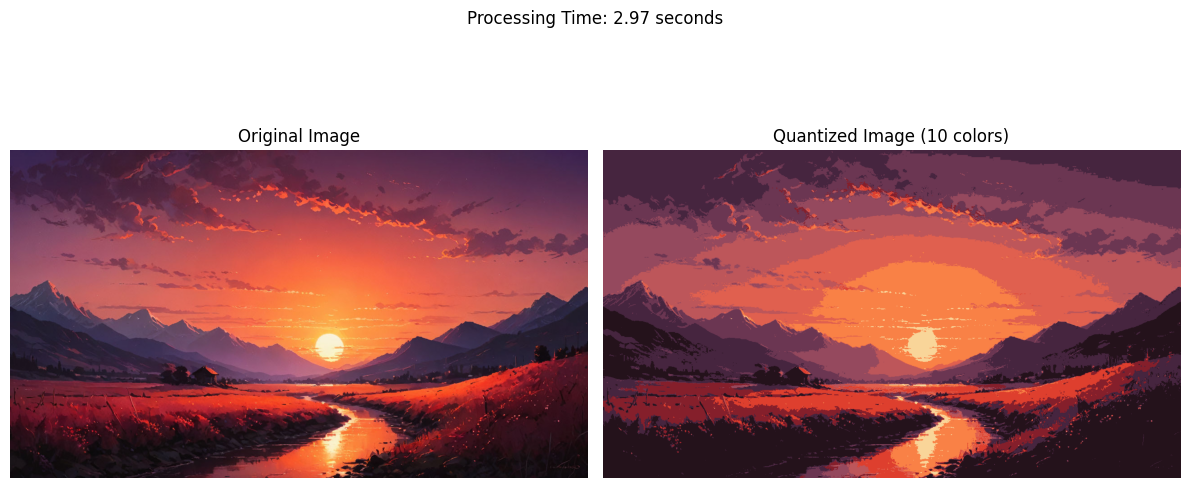

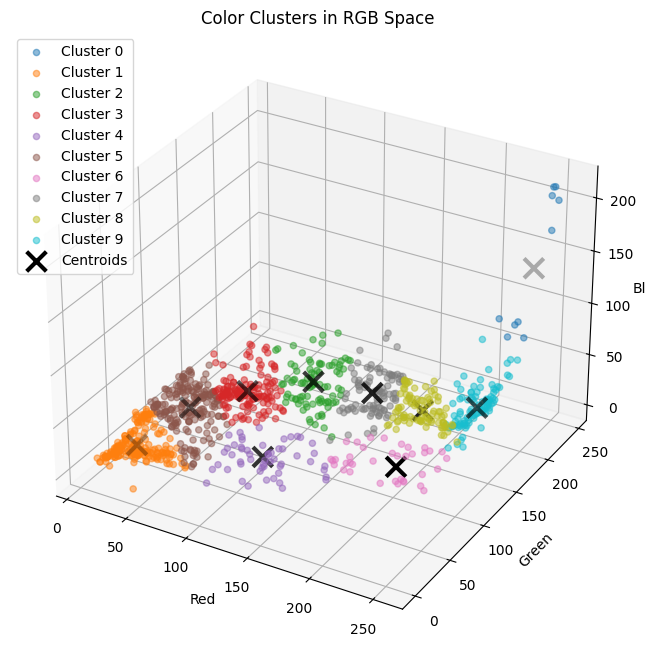

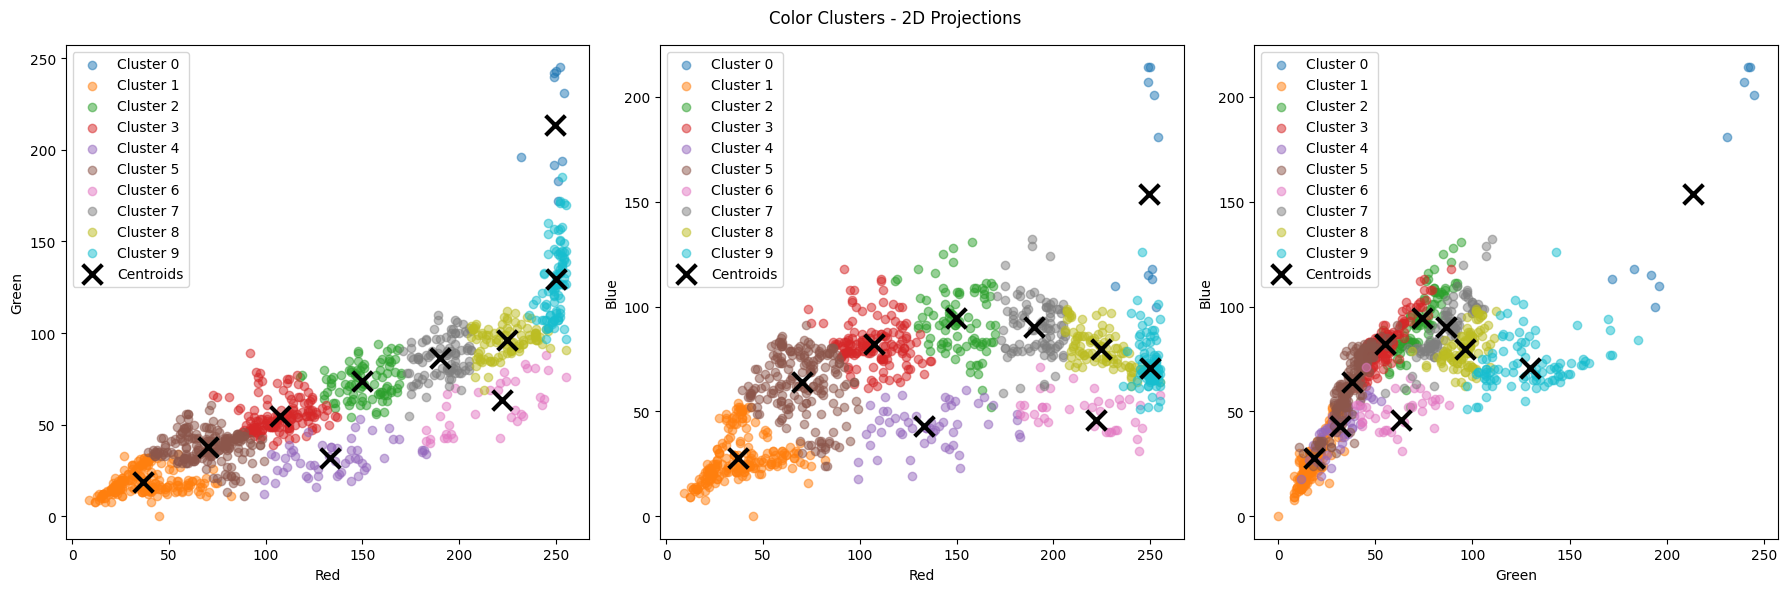

In [22]:
import sys
import os
import numpy as np
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from K_Means_Clustering.k_means import KMeans
import time

def quantize_image(image_path, n_clusters, max_iter):
    # Load and process image
    image = Image.open(image_path)
    N, M = image.size
    X = np.asarray(image).reshape((N * M, 3))
    
    # Initialize and fit K-means
    start_time = time.time()
    km = KMeans(n_clusters=n_clusters, max_iter=max_iter)
    cluster_means, image_data_with_clusters = km.fit(X)
    
    # Extract cluster assignments
    clusters = image_data_with_clusters[:, -1].astype(int)
    
    # Create quantized image
    transformed_X = np.zeros(X.shape)
    for i, cluster in enumerate(clusters):
        transformed_X[i, :] = cluster_means[cluster]
    
    process_time = time.time() - start_time
    print(f"Processing time: {process_time:.2f} seconds")
    
    # Print cluster distribution
    unique_clusters, counts = np.unique(clusters, return_counts=True)
    print("\nCluster Distribution:")
    for cluster, count in zip(unique_clusters, counts):
        percentage = (count / len(clusters)) * 100
        print(f"Cluster {cluster}: {count} pixels ({percentage:.2f}%)")
    
    # Create and display quantized image
    quantized_array = transformed_X.astype('uint8').reshape((M, N, 3))
    quantized_image = Image.fromarray(quantized_array)
    
    # Display original vs quantized image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    ax[1].imshow(quantized_image)
    ax[1].set_title(f"Quantized Image ({n_clusters} colors)")
    ax[1].axis("off")
    plt.suptitle(f'Processing Time: {process_time:.2f} seconds')
    plt.tight_layout()
    plt.show()
    
    # Visualize clusters
    visualize_clusters_3d(X, clusters, cluster_means)
    visualize_clusters_2d(X, clusters, cluster_means)

# Run the quantization
image_path = 'images/bigimage2.jpg'
quantize_image(image_path, n_clusters=10, max_iter=10)

In [25]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from k_means_cuda import KMeans as KMeans_GPU

def quantize_image_gpu(image_path: str, n_clusters: int = 4, max_iter: int = 100):
    # Load and process image
    image = Image.open(image_path)
    N, M = image.size
    X = np.asarray(image).reshape((N * M, 3)).astype(np.float32)
    
    # Run GPU K-means
    start_time = time.time()
    km = KMeans_GPU(n_clusters=n_clusters, max_iter=max_iter)
    km.fit(X)
    labels = km.predict(X)
    quantized_pixels = km.centroids[labels]
    process_time = time.time() - start_time
    
    print(f"GPU Processing time: {process_time:.2f} seconds")
    
    # Print cluster distribution
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("\nCluster Distribution:")
    for label, count in zip(unique_labels, counts):
        percentage = (count / len(labels)) * 100
        print(f"Cluster {label}: {count} pixels ({percentage:.2f}%)")
    
    # Create and display quantized image
    quantized_array = quantized_pixels.reshape((M, N, 3))
    quantized_image = Image.fromarray(quantized_array.astype(np.uint8))
    
    # Display original vs quantized image
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    ax[1].imshow(quantized_image)
    ax[1].set_title(f"Quantized Image ({n_clusters} colors)")
    ax[1].axis("off")
    plt.suptitle(f'GPU Processing Time: {process_time:.2f} seconds')
    plt.tight_layout()
    plt.show()
    
    # Visualize clusters in 3D and 2D
    visualize_clusters_3d(X, labels, km.centroids)
    visualize_clusters_2d(X, labels, km.centroids)

GPU Processing time: 0.69 seconds

Cluster Distribution:
Cluster 0: 3197 pixels (0.34%)
Cluster 1: 174717 pixels (18.75%)
Cluster 2: 115815 pixels (12.43%)
Cluster 3: 57720 pixels (6.19%)
Cluster 4: 57331 pixels (6.15%)
Cluster 5: 80436 pixels (8.63%)
Cluster 6: 168686 pixels (18.10%)
Cluster 7: 47921 pixels (5.14%)
Cluster 8: 143665 pixels (15.42%)
Cluster 9: 82352 pixels (8.84%)


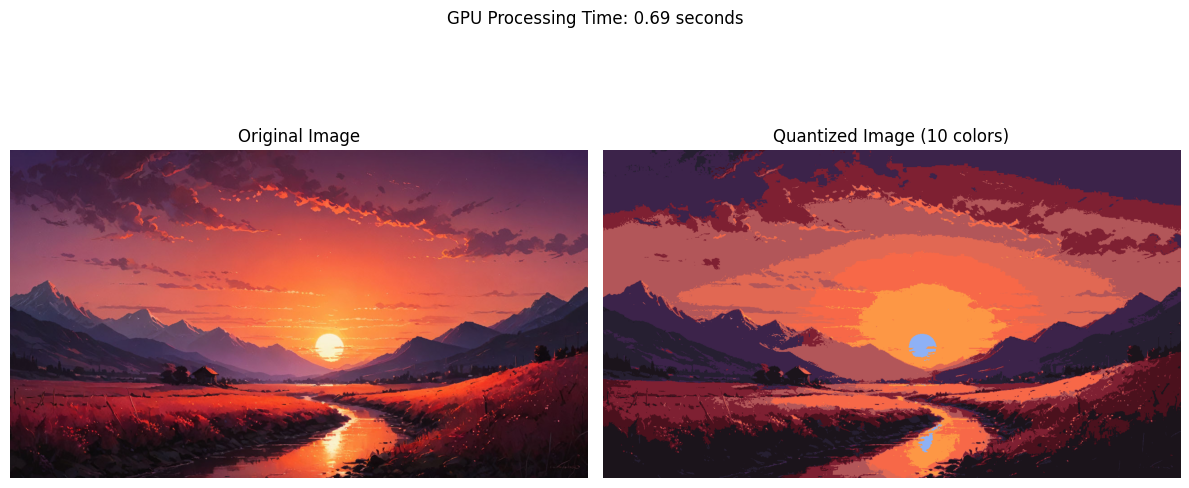

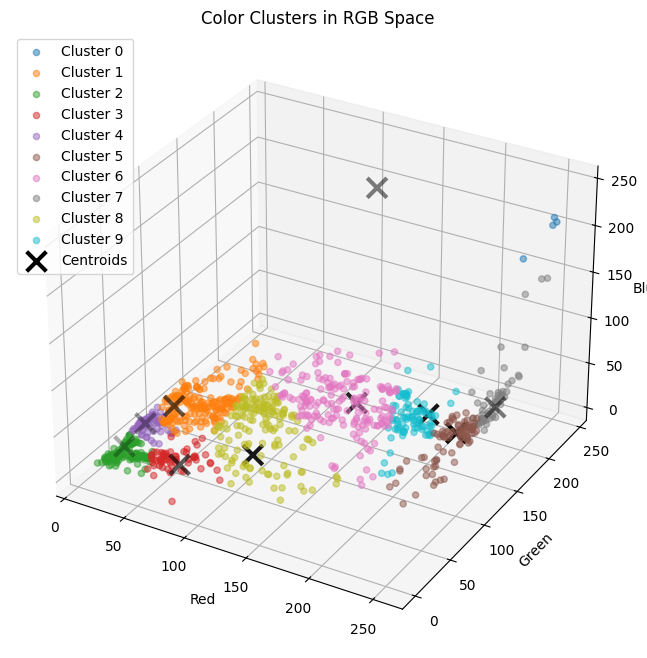

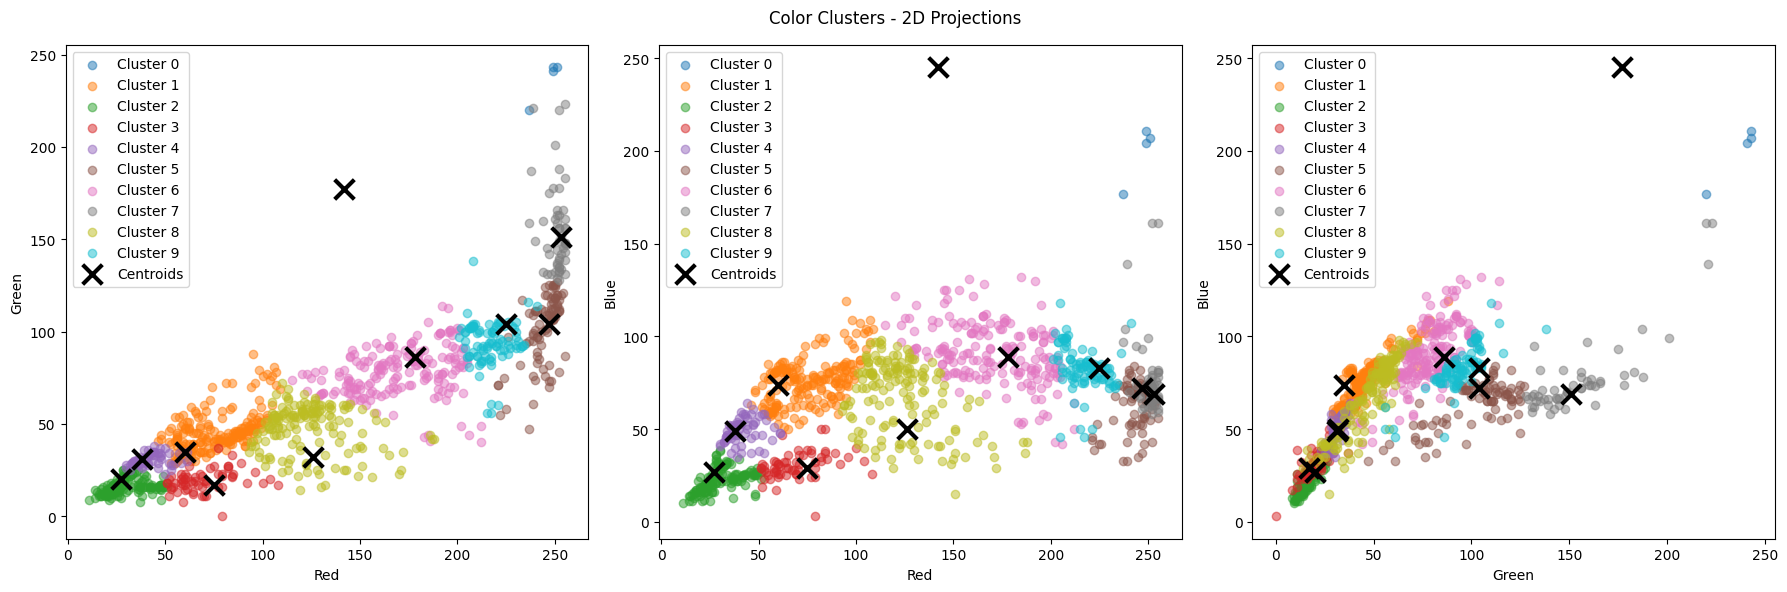

In [26]:
quantize_image_gpu("images/bigimage2.jpg", n_clusters=10, max_iter=10)